In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from memoryraster import MemoryRaster

era5_file = "79a080c8aaa9b3f1d4808e650202035c.nc"
ERA5_VARIABLE_MAPPINGS = {"2m_temperature": "t2m"}

# Columns to keep in zonal statistics output
ADM_COLS = ["ADM1_PCODE","ADM1_EN", "ADM2_PCODE", "ADM2_EN"]

city_polygons = gpd.read_file("data/vnm_adm_gov_20201027/vnm_admbnda_adm2_gov_20201027.shp").to_crs("EPSG:4326")
population_high = MemoryRaster.read("data/vnm_ppp_2020_UNadj_constrained.tif", crs="EPSG:4326")

In [2]:
city_polygons[ADM_COLS]

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN
0,VN411,Thua Thien Hue,VN41115,A Luoi
1,VN813,Kien Giang,VN81315,An Bien
2,VN103,Hai Phong city,VN10313,An Duong
3,VN603,Gia Lai,VN60311,An Khe
4,VN103,Hai Phong city,VN10315,An Lao
...,...,...,...,...
703,VN106,Bac Ninh,VN10603,Yen Phong
704,VN211,Tuyen Quang,VN21109,Yen Son
705,VN403,Nghe An,VN40323,Yen Thanh
706,VN221,Bac Giang,VN22103,Yen The


In [3]:
def get_extents(gdf: gpd.GeoDataFrame) -> tuple[slice, slice]:
    min_long, min_lat, max_long, max_lat = gdf.geometry.total_bounds
    return slice(int(min_long), int(max_long) + 1), slice(int(max_lat+1), int(min_lat))

In [4]:
population_masked_high_m = population_high.mask(city_polygons).astype(np.float32)
population_masked_high_m

<MemoryRaster (17796, 8789) CRS=EPSG:4326 min=1.0159043073654175 max=28730.828125 NODATA=0 file=None
  transform=| 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|>

In [5]:
def era5_raster(ds: xr.Dataset, variable: str, gdf: gpd.GeoDataFrame) -> xr.DataArray:
    varname = ERA5_VARIABLE_MAPPINGS.get(variable, variable)
    data = ds[varname]

    # ERA5 stores longitude from the 0 to 360 scale
    # with 0 at the Greenwich meridian, counting east
    data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
    data = data.sortby(data.longitude)
    # crop to geometry extent
    extent_long, extent_lat = get_extents(gdf)
    return data.sel(longitude = extent_long, latitude = extent_lat)

era5 = xr.open_dataset(era5_file)
ds = era5_raster(era5, '2m_temperature', city_polygons)

<Axes: >

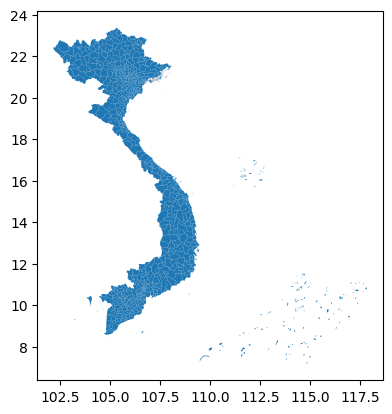

In [16]:
city_polygons.plot()

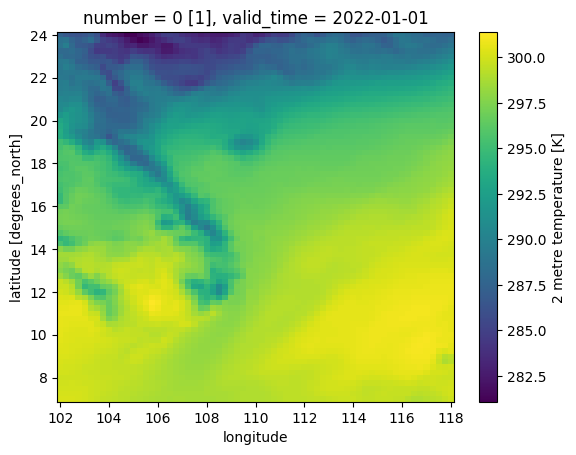

In [7]:
vietnam_weather = era5_raster(era5, '2m_temperature', city_polygons).sel(valid_time="2022-01-01")
vietnam_weather.plot(x="longitude")

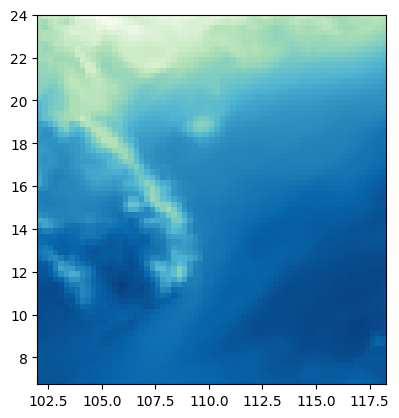

<Axes: >

In [8]:
weather_m = MemoryRaster.from_xarray(vietnam_weather)
weather_m.plot()

Resampling using: 13


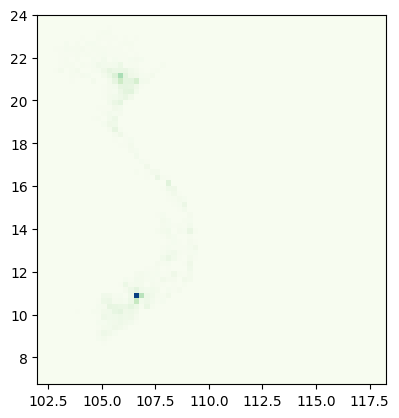

<Axes: >

In [9]:
from rasterio.enums import Resampling
population_m = population_masked_high_m.resample(weather_m, Resampling.sum)
population_m.plot()

In [10]:
zs = weather_m.zonal_stats(city_polygons, 'mean(coverage_weight=area_spherical_m2)', weights=population_m, include_cols=["ADM2_EN", "ADM1_EN"], include_geom=True)
zs

/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


,ADM2_EN,ADM1_EN,mean,geometry
0,A Luoi,Thua Thien Hue,291.904985,"POLYGON ((107.0898 16.44847, 107.09281 16.4468..."
1,An Bien,Kien Giang,299.556743,"POLYGON ((105.1205 9.85495, 105.12673 9.8455, ..."
2,An Duong,Hai Phong city,289.953308,"POLYGON ((106.57189 20.93209, 106.57247 20.931..."
3,An Khe,Gia Lai,293.126593,"POLYGON ((108.68734 14.12817, 108.68975 14.125..."
4,An Lao,Hai Phong city,289.989424,"POLYGON ((106.48482 20.86676, 106.48501 20.866..."
...,...,...,...,...
703,Yen Phong,Bac Ninh,289.558494,"POLYGON ((106.00081 21.25876, 106.00204 21.258..."
704,Yen Son,Tuyen Quang,289.416905,"POLYGON ((105.21609 22.06923, 105.21638 22.069..."
705,Yen Thanh,Nghe An,291.110953,"POLYGON ((105.4597 19.13712, 105.46076 19.1370..."
706,Yen The,Bac Giang,288.779067,"POLYGON ((106.16302 21.62403, 106.16382 21.623..."


In [14]:
from exactextract.feature import GeoPandasFeatureSource
from exactextract.raster import RasterioRasterSource, XArrayRasterSource
GeoPandasFeatureSource(city_polygons).srs_wkt()

'GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]'

In [25]:
with population_m.as_rasterio() as rast:
    wkt = RasterioRasterSource(rast).srs_wkt()

In [26]:
wkt

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [133]:
from tqdm.notebook import tqdm
def yearly_era5_zonal_statistics(dataset: xr.Dataset, variable: str, gdf: gpd.GeoDataFrame, population: MemoryRaster, statistic: str, operation: str = 'mean(coverage_weight=area_spherical_m2)') -> pd.DataFrame:
    da = era5_raster(dataset, variable, gdf)
    min_date = da.valid_time.min().dt.date.item(0)
    max_date = da.valid_time.max().dt.date.item(0)

    # Empty dataframe with output columns
    out = pd.DataFrame(data = [], columns=ADM_COLS + ["value", "date"])

    for date in tqdm(pd.date_range(min_date, datetime.date(2022,6,30), inclusive="both")):
        arr = da.sel(valid_time = date.isoformat())
        rast = MemoryRaster.from_xarray(arr)
        df = rast.zonal_stats(city_polygons, operation, weights=population, include_cols=ADM_COLS).rename(columns={"mean": "value"})
        df['date'] = date
        out = pd.concat([out, df])
    out['metric'] = f'era5.{variable}.{statistic}'
    out['isoweek'] = out['date'].dt.isocalendar().year.astype(str) + '-W' + out['date'].dt.isocalendar().week.astype(str).str.zfill(2)
    return out
    

In [134]:
df = yearly_era5_zonal_statistics(era5, '2m_temperature', city_polygons, population_m, statistic='daily_mean')

  0%|          | 0/181 [00:00<?, ?it/s]

/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/var/folders/2t/8v1v9w8s191f91fnq_f9t0600000gn/T/ipykernel_75308/3075861186.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_ex

In [136]:
weekly = df.groupby(ADM_COLS + ['isoweek']).value.mean().reset_index().sort_values('isoweek')
weekly

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,isoweek,value
0,VN101,Ha Noi,VN10101,Ba Dinh,2021-W52,290.048492
13770,VN701,Ho Chi Minh city,VN70141,Nha Be,2021-W52,300.323789
2727,VN115,Thai Binh,VN11503,Quynh Phu,2021-W52,290.423515
13797,VN701,Ho Chi Minh city,VN70143,Can Gio,2021-W52,300.078122
18603,VN819,Soc Trang,VN81912,Nga Nam,2021-W52,299.832390
...,...,...,...,...,...,...
12176,VN603,Gia Lai,VN60323,Krong Pa,2022-W26,300.523287
12149,VN603,Gia Lai,VN60322,Ia Pa,2022-W26,300.450921
12122,VN603,Gia Lai,VN60321,Ayun Pa,2022-W26,300.729844
12338,VN605,Dak Lak,VN60505,Ea Sup,2022-W26,300.881043
